In [267]:
try: import simplejson as json
except ImportError: import json

import gzip,codecs,numpy as np,random,copy
import scipy.optimize as opt
import matplotlib.pyplot as plt

In [268]:
#with open("finefood_train_random.json","r") as infile:
#with open("beeradvocate_train_random.json","r") as infile:
#with open("beeradvocate_train_lastrating.json","r") as infile:
#with open("ratebeer_train_lastrating.json","r") as infile:
with open("ratebeer_train_random.json","r") as infile:
    train = json.load(infile)
infile.close()
#with open("finefood_test_random.json","r") as infile:
#with open("beeradvocate_test_random.json","r") as infile:
#with open("beeradvocate_test_lastrating.json","r") as infile:
#with open("ratebeer_test_lastrating.json","r") as infile:
with open("ratebeer_test_random.json","r") as infile:
    test = json.load(infile)
infile.close()
#with open("finefood_quickmap_random.json","r") as infile:
#with open("beeradvocate_quickmap_random.json","r") as infile:
#with open("beeradvocate_quickmap_lastrating.json","r") as infile:
#with open("ratebeer_quickmap_lastrating.json","r") as infile:
with open("ratebeer_quickmap_random.json","r") as infile:
    quickmap = json.load(infile)
infile.close()

print(len(train),len(test),len(quickmap))
train = sorted(train, key = lambda k : int(k["review/time"]))

2704815 4760 2709575


In [269]:
Iu = dict() #set of products reviewed by users
Ui = dict() #set of users who reviewed the product

In [270]:
for review in train:
        item = review["product/productId"]
        user = review["review/userId"]
        if item in Ui:
            Ui[item].append(user)
        else:
            Ui[item] = [user]
        if user in Iu:
            Iu[user].append(item)
        else:
            Iu[user] = [item]

In [271]:
#with open("finefood_user_map_random.json",'r') as infile:
#with open("beeradvocate_user_map_lastrating.json",'r') as infile:
#with open("ratebeer_user_map_lastrating.json",'r') as infile:
with open("ratebeer_user_map_random.json",'r') as infile:
        user_map = json.load(infile)
infile.close()
#with open("finefood_item_map_random.json",'r') as infile:
#with open("beeradvocate_item_map_lastrating.json",'r') as infile:
#with open("ratebeer_item_map_lastrating.json",'r') as infile:
with open("ratebeer_item_map_random.json",'r') as infile:
        item_map = json.load(infile)
infile.close()

user_map_int = {}
for key in user_map:
    user_map_int[int(key)] = user_map[key]
item_map_int = {}
for key in item_map:
    item_map_int[int(key)] = item_map[key]

In [272]:
#with open("beeradvocate_lastrating_eui.json",'r') as infile:
with open("ratebeer_random_eui.json",'r') as infile:
#with open("finefood_random_eui.json",'r') as infile:
    eui_dict = json.load(infile)

In [273]:
eui = {}
for key in eui_dict:
    try:
        user,item = key.split('<?>')
        #user,item = key.split('-')

        if user not in eui:
            eui[user]= {}
        eui[user][item] = eui_dict[key]
    except Exception as f:
        print(key, f)

In [274]:
#with open("beeradvocate_user_expertise_lfm_results_lastrating",'r') as infile:
with open("ratebeer_user_expertise_lfm_results_random",'r') as infile:
    flat_theta = infile.read().split()

In [275]:
flat_theta = np.array(flat_theta, np.float64)

In [276]:
E=5
k=5

In [277]:
alpha_G = 0                                #global offset
Bu_G = dict()                                        #user bias (global)
Bi_G = dict()                                        #item bias (global)
alpha = np.random.rand(E)                     #individual offset parameters per exp
Bu = [dict() for i in range(E)]               #user bias per exp
Bi = [dict() for i in range(E)]               #item bias per exp
Gu = [dict() for i in range(E)]               #user latent factor vector repr per exp
Gi = [dict() for i in range(E)] 

In [278]:
def retrieve_theta_components(theta,user_map, item_map):
        ''' Sets all parameters from the long theta vector obtained after update rule'''
        global alpha_G, Bu_G, Bi_G, alpha, Bu, Bi, Gu, Gi
        j = 0
        umap_len = len(user_map)
        imap_len = len(item_map)
        alpha_G = theta[j]
        j+=1
        for i in range(umap_len):
            Bu_G[user_map[i]] = theta[j]
            j+=1
        for i in range(imap_len):
            Bi_G[item_map[i]] = theta[j]
            j+=1 
        for e in range(E):
            alpha[e] = theta[j]
            j+=1   
        for e in range(E):
            for i in range(umap_len):
                Bu[e][user_map[i]] = theta[j]
                j+=1
        for e in range(E):
            for i in range(imap_len):
                Bi[e][item_map[i]] = theta[j]
                j+=1 
        for e in range(E):
            for i in range(umap_len):
                Gu[e][user_map[i]] = np.array(theta[j:j+k])
                j+=k  
        for e in range(E):
            for i in range(imap_len):
                Gi[e][item_map[i]] = np.array(theta[j:j+k])
                j+=k   
        if j!= len(theta):
            print("Something went wrong. Not all theta values were used")
        print(j)
            
    

In [279]:
retrieve_theta_components(flat_theta,user_map_int, item_map_int)

3558558


In [280]:
def pred_e(user,item,e):
    global alpha_G, Bu_G, Bi_G, alpha, Bu, Bi, Gu, Gi
    return alpha_G + Bu_G[user] + Bi_G[item] + alpha[e] + Bu[e][user] + Bi[e][item] +\
                      np.asscalar(np.dot(Gu[e][user], Gi[e][item].T))
            
def mse_test(test_data):
        ''' Uses Mean Squared Error as evaluation metric on test data provided by user'''
        global alpha_G, Bu_G, Bi_G, alpha, Bu, Bi, Gu, Gi,eui
        #retrieve_theta_components(final_param)
        mse = np.zeros(E)
        count = np.zeros(E)
        error = 0
        unknown_data_count =0;
        for review in test_data:
            user = review["review/userId"]
            item = review["product/productId"]
            #assign nearest experience to user-item combo
            rtime = int(review["review/time"])
            time_arr = []
            for i in range(len(Iu[user])):
                it = Iu[user][i]
                time_arr.append(int(quickmap[user+"-"+it]["review/time"]))
            for i in range(len(time_arr)-1):
                if time_arr[i] > time_arr[i+1]:
                    print("aksks")
                    break
            #if all(time_arr[i] <= time_arr[i+1] for i in range(len(time_arr)-1))==False:
            #    print("raising error. Something went wrong. List should be sorted by default")
            index = np.searchsorted(time_arr,rtime)
            if index == len(Iu[user]):
                closest_it = Iu[user][index-1]
            else:
                closest_it = Iu[user][index]
            
                e = eui[user][closest_it]
            try:
                error += (pred_e(user,item,e) - review["review/score"])**2
                mse[e] += (pred_e(user,item,e) - review["review/score"])**2
                count[e] +=1
            
            except Exception as f:
                #print(f,user,closest_it)
                unknown_data_count+=1
        
        if unknown_data_count>0:
            print("Warning! Unknown {} new data rows; Incorporating this into MSE".format(unknown_data_count))
        return (error / (len(test_data) - unknown_data_count), mse,count)

In [281]:
error, mse, count = mse_test(test)

Warning! Unknown 13 new data rows; Incorporating this into MSE


In [282]:
mse/count

array([ 0.8797069 ,  0.57999745,  0.54646935,  0.40682949,  0.39121456])

### Experience progression

In [283]:
merged = train #+ test

In [284]:
merged = sorted(merged, key = lambda k : int(k["review/time"]))
Iu = dict()
Ui = dict()
for review in merged:
        item = review["product/productId"]
        user = review["review/userId"]
        if item in Ui:
            Ui[item].append(user)
        else:
            Ui[item] = [user]
        if user in Iu:
            Iu[user].append(item)
        else:
            Iu[user] = [item]

In [285]:
len(Ui)

110032

In [286]:
users1 = []
for user in Iu:
    item1 = Iu[user][0]
    item2 = Iu[user][-1]
    if eui[user][item1]==0 and eui[user][item2]==4:
        users1.append(user)

In [287]:
users2 = []
for user in Iu:
    item1 = Iu[user][0]
    item2 = Iu[user][-1]
    if eui[user][item1]==0 and eui[user][item2]==3:
        users2.append(user)

In [288]:
n_e = np.zeros(E)  #number of ratings per level
time_e = np.zeros(E)
n_u  = np.zeros(E) #number of users per level
for user in users1:
    item = Iu[user][0]
    start_time = float(quickmap[user+'-'+item]['review/time'])
    cur_level= eui[user][item]
    temp_e = np.zeros(E)
    n_u[cur_level] +=1
    for i in range(len(Iu[user])):
        item = Iu[user][i]
        if eui[user][item]== cur_level:
            continue
        else:
            end_time = int(quickmap[user+'-'+item]['review/time'])            
            temp_e[cur_level] += end_time - start_time
            #start_time = end_time
            n_e[cur_level]+=i
            if cur_level==E-1:
                break
            else:
                cur_level+=1
                n_u[cur_level]+=1
    item = Iu[user][-1]
    end_time = float(quickmap[user+'-'+item]['review/time'])
    temp_e[cur_level] += end_time - start_time
    n_e[cur_level]=len(Iu[user])
    time_e += temp_e


In [289]:
n_e2 = np.zeros(E)  #number of ratings per level
time_e2 = np.zeros(E)
n_u2  = np.zeros(E) #number of users per level
for user in users2:
    item = Iu[user][0]
    start_time = float(quickmap[user+'-'+item]['review/time'])
    cur_level= eui[user][item]
    temp_e = np.zeros(E)
    n_u2[cur_level] +=1
    for i in range(len(Iu[user])):
        item = Iu[user][i]
        if eui[user][item]== cur_level:
            continue
        else:
            end_time = int(quickmap[user+'-'+item]['review/time'])            
            temp_e[cur_level] += end_time - start_time
            #start_time = end_time
            n_e2[cur_level]+=i
            if cur_level==E-2:
                break
            else:
                cur_level+=1
                n_u2[cur_level]+=1
    item = Iu[user][-1]
    end_time = float(quickmap[user+'-'+item]['review/time'])
    temp_e[cur_level] += end_time - start_time
    n_e2[cur_level]=len(Iu[user])
    time_e2 += temp_e


In [290]:
time_e/(7*24*60*60)/n_u

array([  44.62474316,   81.74532281,  122.78263221,  166.74164594,
        217.64896723])

In [291]:
time_e2/(7*24*60*60)/n_u2

/Users/kirankannar/tensorflow/lib/python3.6/site-packages/ipykernel_launcher.py:1: RuntimeWarning: invalid value encountered in true_divide
  """Entry point for launching an IPython kernel.


array([  63.49769585,  104.36449418,  140.92560895,  202.14483213,
                 nan])

### Ratebeer

/Users/kirankannar/tensorflow/lib/python3.6/site-packages/ipykernel_launcher.py:3: RuntimeWarning: invalid value encountered in true_divide
  This is separate from the ipykernel package so we can avoid doing imports until


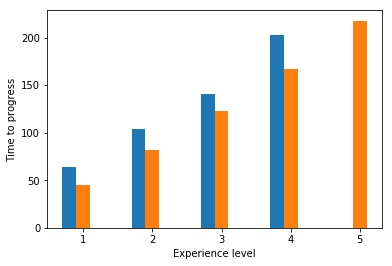

In [299]:
x = np.arange(1,6) 
ax = plt.subplot(111)
plt.bar(x-0.2,time_e2/(7*24*60*60)/n_u2,width=0.2)
plt.bar(x,time_e/(7*24*60*60)/n_u,width=0.2)
plt.ylabel("Time to progress")
plt.xlabel("Experience level")
plt.show()

###  BeerAdvocate

/Users/kirankannar/tensorflow/lib/python3.6/site-packages/ipykernel_launcher.py:3: RuntimeWarning: invalid value encountered in true_divide
  This is separate from the ipykernel package so we can avoid doing imports until


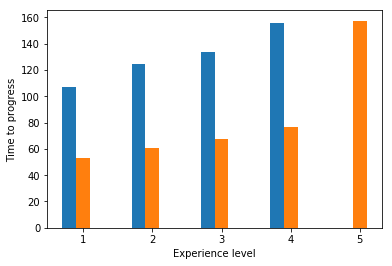

In [237]:
x = np.arange(1,6) 
ax = plt.subplot(111)
plt.bar(x-0.2,time_e2/(7*24*60*60)/n_u2,width=0.2)
plt.bar(x,time_e/(7*24*60*60)/n_u,width=0.2)
plt.ylabel("Time to progress")
plt.xlabel("Experience level")
plt.show()

In [296]:
delta = np.zeros(len(item_map_int))

for i in range(len(item_map_int)):
    item = item_map_int[i]
    delta[i] = -(Bi[E-1][item] - Bi[0][item])


In [294]:
avg_p = np.zeros(len(item_map_int))
for i in range(len(item_map_int)):
    item = item_map_int[i]
    tot = 0
    for user in Ui[item]:
        tot += quickmap[user+'-'+item]["review/score"]
    tot/=len(Ui[item])
    avg_p[i] = tot
                      

In [298]:
plt.scatter(avg_p, delta)
#plt.ylim(-0.009, 0.009)
plt.show()

In [300]:
def parse(filename):
  #f = gzip.open(filename, 'r')
  f = codecs.open(filename,encoding='latin-1')
  entry = {}
  for l in f:
    l = l.strip()
    colonPos = l.find(':')
    if colonPos == -1:
      yield entry
      entry = {}
      continue
    eName = l[:colonPos]
    rest = l[colonPos+2:]
    entry[eName] = rest
  yield entry

In [301]:
ratebeer_data = []
for e in parse("ratebeer.txt"):
    ratebeer_data.append(e)

In [302]:
print("Number of Ratebeer beer reviews: {}".format(len(ratebeer_data)))

Number of Ratebeer beer reviews: 2924164


In [304]:
beer_namedict= {}
for review in ratebeer_data:
    if 'beer/beerId' in review and 'beer/name' in review:
        beerid = review['beer/beerId']
        beername = review['beer/name']
        beer_namedict[beerid] = beername

In [305]:
beginner_bias = {}
expert_bias = {}

for i in range(len(item_map_int)):
    item = item_map_int[i]
    beginner_bias[item] = Bi_G[item]+ Bi[0][item]
    expert_bias[item] = Bi_G[item]+ Bi[E-1][item]